<div width=50% style="display: block; margin: auto">
    <img src="figures/ucl-logo.svg" width=100%>
</div>

### UCL-ELEC0136 Data Acquisition and Processing Systems 2024
University College London
# Lab 5: Feature engineering
<hr>

### Objectives

- Gain practical experience of dealing with real-world data
- Develop intuition and understanding of how operations on input features can affect model performance, and when to use them
- Develop familiarity different methods for assessing feature importance

### Outline

0. [Setup](#0-setup)
1. [Dealing with missing values](#1-dealing-with-missing-values)
2. [Transforming the distributions of features](#2-transforming-the-distributions-of-features)
3. [Discretising an input feature](#3-discretising-an-input-feature)
4. [Feature selection](#4-feature-selection)

<hr>

## 0. Setup


### 0.1 Prerequisites
First, we need to install the necessary packages for this lab. The packages are:

- `ucimlrepo`: real-life datasets for machine learning
- `scikit-learn`: statistical machine learning models
- `shap`: importance/relevancy metrics

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 0.1: Install prerequisites</h4>

Install the packages that are required for this lab.

<details>
<summary>🔎 Hint</summary>

Remember, there are two steps to adding packages to your `daps` Python environment. You need to:
1. **Add the package to the requirements file**.
2. **Install all the requirements in the requirements file.**

</details>

</div>

### 0.2 Fetching the dataset

We'll be using a dataset containing data from a heart disease study in Cleveland, OH, USA.
Using this data, we should be able to predict whether a patient has heart disease, given various measurements that can be taken by a doctor.

For a more detailed explanation of the dataset, see [here](https://archive.ics.uci.edu/dataset/45/heart+disease).

In [1]:
from ucimlrepo import fetch_ucirepo 
import ssl

# Ignore ssl certificate verification
# We have to do this because in between writing the lab and delivering it, the SSL certificate of the UCIML website expired.
# This is a hacky fix. It is terrible practice.
# The correct thing to do would be to pester the website owners to update their SSL certificate, but we didn't have time.
ssl._create_default_https_context = ssl._create_unverified_context

heart_disease = fetch_ucirepo(id=45) 
  
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
heart_disease.variables 

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [2]:
# Show some example inputs
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [3]:
# Show some example outputs
y.head()

,num
0,0
1,2
2,1
3,0
4,0


Here, `num` is nonzero if the patient has some form of heart disease. We need to encode this to a binary variable (`0` or `1`).

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 0.1: Encode output variable</h4>

Modify the `y` DataFrame so that entries are `1` if the patient has some form of heart disease and `0` otherwise.
</div>

In [4]:
# Add your code here:
y.loc[y['num'] > 1, 'num'] = 1
y.head()

C:\Users\qy\AppData\Local\Temp\ipykernel_3368\3737216064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y['num'] > 1, 'num'] = 1


,num
0,0
1,1
2,1
3,0
4,0


When evaluating the performance of a model, we need some data that the model hasn't seen. `scikit-learn` provides a handy function for producing a "test" (held-out) set, that is only used during evaluation:

In [5]:
from sklearn.model_selection import train_test_split

help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

Note that we should preferably also use a *validation* set, but we're skipping it here for simplicity.

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 0.2: Create training and test sets</h4>

Using `train_test_split` only, shuffle the `(X, y)` data and split it into a training and a test set, with 80% of the data in the training set.

For reproducibility, create a variable, `seed`, and set it to `42`. Use this to set the `random_state` of `train_test_split`. We'll reuse this variable in future to reseed other random processes.

Your variable names should be `(X_train, y_train)` and `(X_test, y_test)`.
</div>

In [6]:
# Add your code here:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=seed)

In [7]:
# If this fails, it means you did something wrong!
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [8]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
132,29,1,2,130,204,0,2,202,0,0.0,1,0.0,3.0
202,57,1,3,150,126,1,0,173,0,0.2,1,1.0,7.0
196,69,1,1,160,234,1,2,131,0,0.1,2,1.0,3.0
75,65,0,3,160,360,0,2,151,0,0.8,1,0.0,3.0
176,52,1,4,108,233,1,0,147,0,0.1,1,3.0,7.0


In [9]:
y_train.head()

,num
132,0
202,0
196,0
75,0
176,0


### 0.3 Using a machine learning model

In this lab, we'll be using a [*support vector machine*](https://scikit-learn.org/stable/modules/svm.html) classifier. This is a simple but powerful statistical learning model provided by `scikit-learn`.

> Understanding the inner workings of this model is not the point of this lab, so we treat it as a black box.

We'll demo the SVM here using a **different** dataset:

In [10]:
from sklearn.datasets import load_iris
from models import support_vector_machine

# Load the iris dataset
X_iris, y_iris = load_iris(return_X_y=True)
# Train/test split
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris, y_iris, random_state=42)

model = support_vector_machine.train(X_iris_train, y_iris_train)
support_vector_machine.evaluate(model, X_iris_train, y_iris_train, X_iris_test, y_iris_test)

Score on training set: 95.54%
Score on test set: 100.00%


Note the functions we're using: 

- `support_vector_machine.train` takes in the training data and returns a trained classifier
- `support_vector_machine.evaluate` takes in the trained classifier, the training data, and the test data, and prints the score on the training and test sets.

In the rest of the lab, you'll see how the performance of the classifier on the **heart disease dataset** can be affected by feature engineering. At each stage, we'll retrain the model on the feature-engineered data and see how it performs.

<hr>

## 1. Dealing with missing values

The first thing to do when receiving data is to check whether there are any missing values.

As `X_train` is a `pd.DataFrame`, we can use the `isna` (short for "is not applicable" or "is not a number") method to generate a table that has `0` where the values are present, and `1` if the values are missing.

In [11]:
import pandas as pd
help(pd.DataFrame.isna)

Help on function isna in module pandas.core.frame:

isna(self) -> 'DataFrame'
    Detect missing values.
    
    Return a boolean same-sized object indicating if the values are NA.
    NA values, such as None or :attr:`numpy.NaN`, gets mapped to True
    values.
    Everything else gets mapped to False values. Characters such as empty
    strings ``''`` or :attr:`numpy.inf` are not considered NA values
    (unless you set ``pandas.options.mode.use_inf_as_na = True``).
    
    Returns
    -------
    DataFrame
        Mask of bool values for each element in DataFrame that
        indicates whether an element is an NA value.
    
    See Also
    --------
    DataFrame.isnull : Alias of isna.
    DataFrame.notna : Boolean inverse of isna.
    DataFrame.dropna : Omit axes labels with missing values.
    isna : Top-level isna.
    
    Examples
    --------
    Show which entries in a DataFrame are NA.
    
    >>> df = pd.DataFrame(dict(age=[5, 6, np.nan],
    ...                       

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- *Methods* are like functions that 'belong' to a specific object.
- In the output of the `help` command above, there's an example of using the `isna` method of a `pd.DataFrame` object.
- In `pandas`, you can often chain together methods on DataFrames in one line, like this:
  ```python
  X_train.sum().max()
  ```
- You might want to have the DataFrame documentation page open so that you can easily find any methods you need - this section should be solved using DataFrame methods alone (i.e., without manually iterating over rows in the data).

</div>

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 1.1: Compute the percentage of missing values</h4>

Using methods of the `X_train` DataFrame, compute the percentage of missing values for each input feature.

</div>

In [12]:
# Add your code here:
# percentage
X_train.isna().mean()*100

age         0.000000
sex         0.000000
cp          0.000000
trestbps    0.000000
chol        0.000000
fbs         0.000000
restecg     0.000000
thalach     0.000000
exang       0.000000
oldpeak     0.000000
slope       0.000000
ca          1.239669
thal        0.826446
dtype: float64

The missing values seem to only occur in two input features, and are missing in only a small amount of the training data.

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 1.2: Deal with the missing values</h4>

For each feature that has missing values:

- Visualise the distribution of the values for that feature using a bar chart
  - Remember to label your axes
  - [Optional] If you like, you could also display bars for the NaN entries, which allows you to compare their frequency with the other categories
- Select a method for dealing with the missing values, and **justify your answer in the Q/A box below**. Also explain why one *other* method would be **unsuitable**.
- Implement your solution, and evaluate it using `evaluate`
  - Your solution should modify `X_train`, `y_train`, `X_test`, and `y_test`
  - Remember, **imputing missing values in the test set must only be done using information from the training set!**
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- Create a copy of the unmodified dataframes so that if you make a mistake you don't have to re-run the notebook from the beginning!

</div>

In [13]:
# Add your code here:
X_copy = X_train.copy(deep=True)
y_copy = y_train.copy(deep=True)

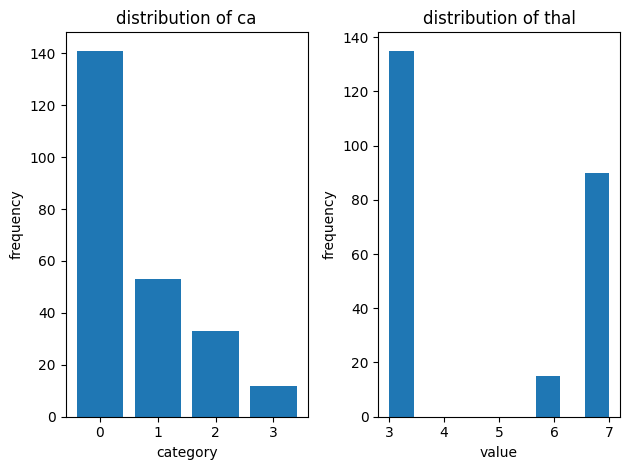

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
#X_copy['ca'].fillna("missing", inplace=True)
category_counts = X_copy['ca'].value_counts()
ax[0].bar(category_counts.index, category_counts.values)
ax[0].set_title("distribution of ca")
ax[0].set_xlabel("category")
ax[0].set_ylabel("frequency")
ax[1].hist(X_copy['thal'], bins='auto')
ax[1].set_title("distribution of thal")
ax[1].set_xlabel("value")
ax[1].set_ylabel("frequency")
plt.tight_layout()

<div class="alert alert-block alert-danger">
<b>Q: What method(s) will you use for dealing with the missing values? Why?</b>
</div>

**A:** Drop NA, only 1%

<div class="alert alert-block alert-danger">
<b>Q: What is an unsuitable method for dealing with the missing values? Why?</b>
</div>

**A:** Fill with 0, change the distribution

In [15]:
# Add your code here:
X_copy = X_train.copy(deep=True)
y_copy = y_train.copy(deep=True)
nan_rows = X_copy.isna().any(axis=1)
X_clean = X_copy[~nan_rows]
y_clean = y_copy[~nan_rows]

print(X_clean.isna().mean()*100)
assert len(X_clean)==len(y_clean)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
dtype: float64


<hr>

## 2. Transforming the distributions of features

Many statistical classifiers work best if the distribution of each input feature follows a Gaussian distribution.

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 2.1: Visualising feature distributions</h4>

- Using `matplotlib`, make a figure comprised of a subplot grid with 2 rows and 7 columns
- On each subplot, plot the **histogram** of one of the input features
- Which of the continuous variables appear to be **not** Gaussian-distributed? Write your answer in the Q/A box.
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- If your figure has overlapping labels or looks a bit squashed, try using `plt.tight_layout()` at the end of the cell.

</div>

continuous features ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'num']


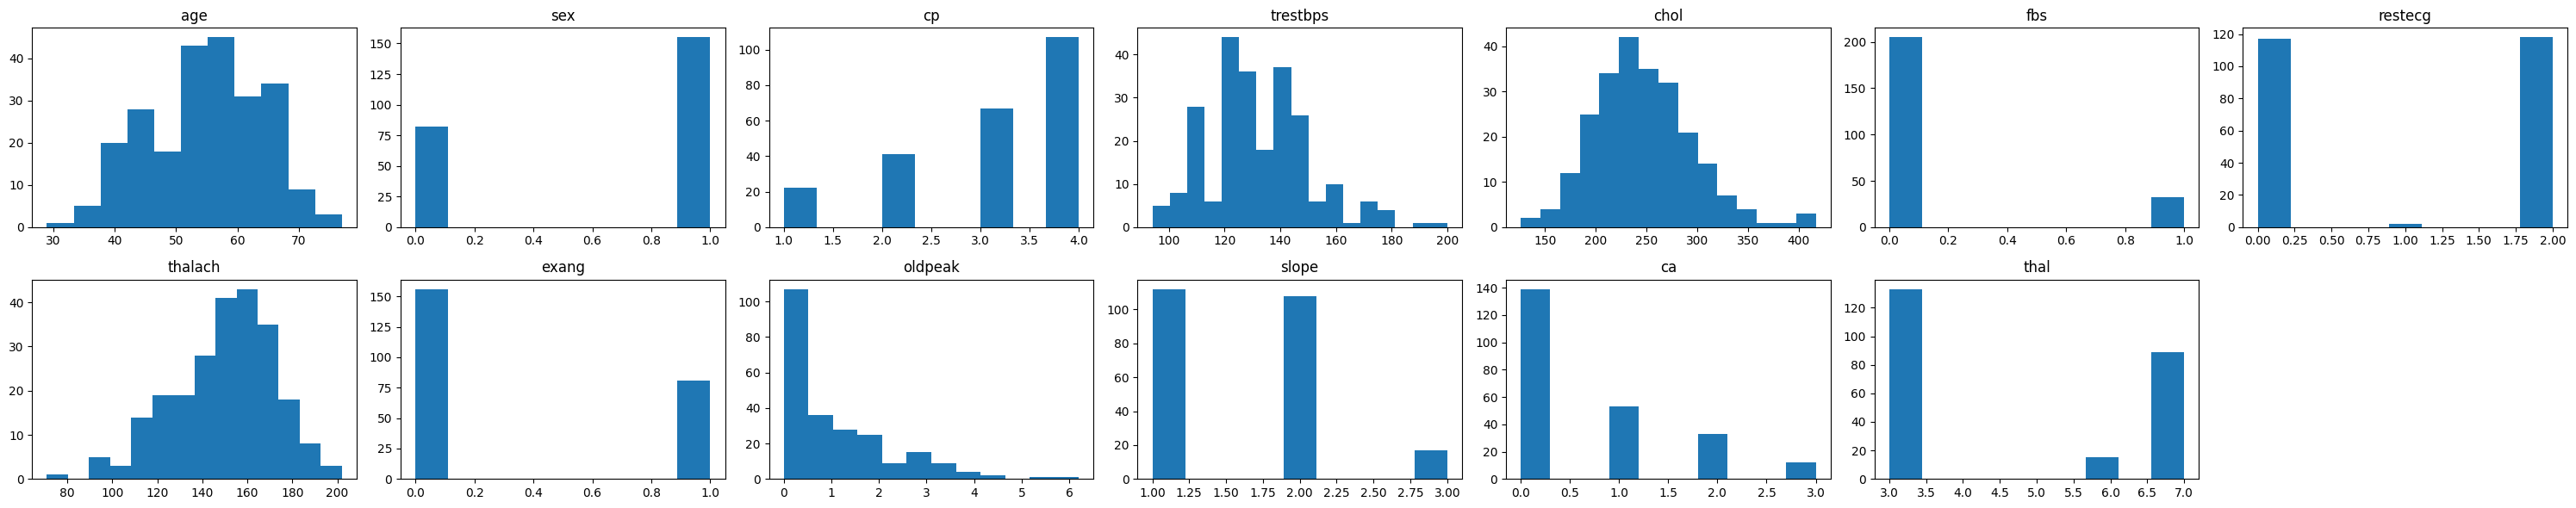

In [16]:
# Add your code here:
# fig, ax = plt.subplots(2,7)
feature_list = X_clean.columns.tolist()
# print("continuous features", X.select_dtypes(include=['int']).columns.tolist())
print("continuous features", ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'num'])
plt.figure(figsize=(30,6))
for i in range(1, 14):
    plt.subplot(2, 7, i)
    plt.hist(X_clean[feature_list[i-1]], bins='auto')
    plt.title(feature_list[i-1])

plt.tight_layout()


<div class="alert alert-block alert-danger">
<b>Q: Which of the continuous variables are not Gaussian distributed?
</div>

**A:** 'age', 'trestbps', 'oldpeak', 'thalach', 'chol'

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 2.2: Transforming the distributions </h4>

- `scipy` provides an implementation of the Yeo-Johnson transformation. Find it (via your favourite search engine) and use it to transform the variables you identified above.
- Evaluate the model on the transformed data, and compare to the scores on the untransformed data.
- How have the scores of the model on the training and test set changed? Have we improved the model's ability to generalise? How do you know? Write your answer in the Q/A box.
- Visualise histograms of the transformed distributions

</div>


<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- Create a copy of the unmodified dataframes so that if you make a mistake you don't have to re-run the notebook from the beginning.
- Remember to re-train the model on the transformed data using `support_vector_machine.train`.

</div>

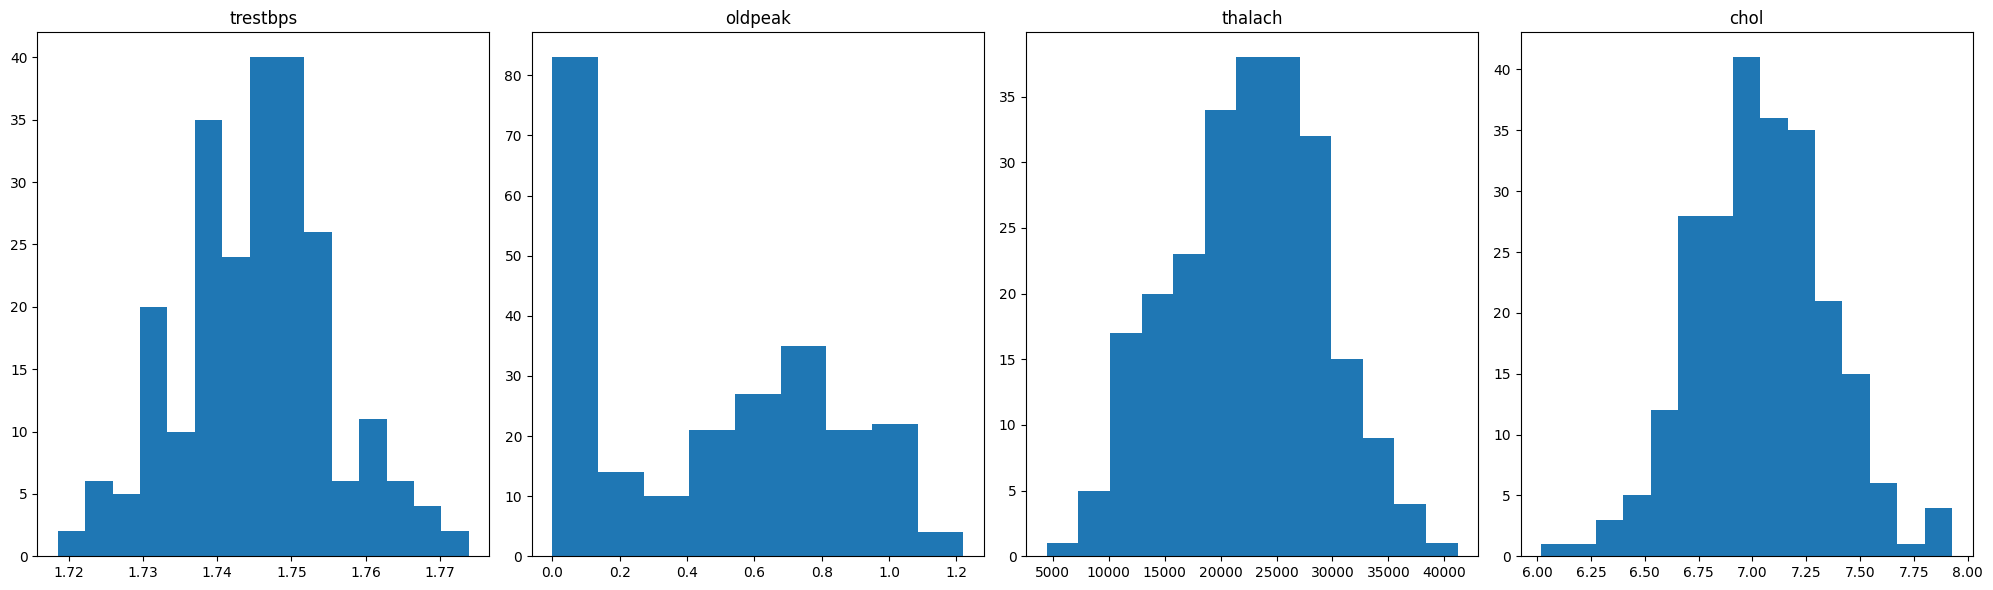

In [17]:
# Add your code here:
#transform_feature_list = ['age', 'trestbps', 'oldpeak', 'thalach', 'chol']
transform_feature_list = ['trestbps', 'oldpeak', 'thalach', 'chol']
lmbda_dict = {}

X_transform = X_clean.copy(deep=True)
y_transform = y_clean.copy(deep=True)
from scipy import stats
for feature in transform_feature_list:
    transform, lmbda = stats.yeojohnson(X_transform[feature])
    lmbda_dict[feature] = lmbda
    X_transform[feature] = transform
plt.figure(figsize=(20,6))
for i in range(1, len(transform_feature_list)+1):
    plt.subplot(1, len(transform_feature_list), i)
    plt.hist(X_transform[transform_feature_list[i-1]], bins='auto')
    plt.title(transform_feature_list[i-1])
plt.tight_layout()


<div class="alert alert-block alert-danger">
<b>Q: How have the scores of the model on the training and test set have changed? Have we improved the model's ability to generalise? How do you know?
</div>

**A**: Yes. Test scores higher

In [18]:
# Add your code here:
X_test_clean = X_test[~X_test.isna().any(axis=1)]
y_test_clean = y_test[~X_test.isna().any(axis=1)]
# print(X_test_clean.isna().mean()*100)
# print(X_clean_copy['oldpeak'])
# print(X_copy_clean['oldpeak'])
X_test_transform = X_test_clean.copy(deep=True)

# X_test_transform.head()
for feature in transform_feature_list:
    transform= stats.yeojohnson(X_test_transform[feature], lmbda=lmbda_dict[feature])
    X_test_transform[feature] = transform

# print(X_transform['oldpeak'].head())
# print(X_clean['oldpeak'].head())
X_test_transform.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
179,53,1,3,1.744980,7.059886,1,2,29597.395635,0,-0.000000,1,3.0,3.0
228,54,1,4,1.731895,6.777389,0,2,10861.038280,1,-0.000000,2,1.0,3.0
111,56,1,4,1.742009,7.079348,1,2,20023.237344,1,0.643604,2,1.0,3.0
246,58,1,4,1.723908,6.979813,0,0,23743.815930,0,0.092927,1,1.0,7.0
60,51,0,4,1.744980,7.408235,0,0,19435.922742,1,0.643604,2,0.0,7.0


In [19]:
# without transform
model1 = support_vector_machine.train(X_clean, y_clean)
support_vector_machine.evaluate(model1, X_clean, y_clean, X_test_clean, y_test_clean)

# with transform
model2 = support_vector_machine.train(X_transform, y_transform)
support_vector_machine.evaluate(model2, X_transform, y_transform, X_test_transform, y_test_clean)

Score on training set: 65.40%
Score on test set: 68.33%
Score on training set: 66.67%
Score on test set: 75.00%


<hr>

## 3. Discretising an input feature

Sometimes, we might want to turn a continuous feature into a discrete one. Sometimes, this is necessary, as some models only work with discrete inputs. Other times, we might find that discretisation improves the model's performance, as it helps it to generalise better.


<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 3.1: Discretising a continuous feature</h4>

- The values in the transformed `thalach` column are high resolution and vary over a large range. This means that they might benefit from being discretised!
- Plot a **cumulative density histogram** of the values in the `thalach` column of the training data.
- Pandas provides `qcut`, a function for discretising a DataFrame based on quantiles (i.e., ensuring that each bin has a similar count). It also provides `cut`, a function for discretising based on predefined bin edges. Using these functions, discretise the `thalach` column into **10 bins**. The bin edges should be such that each bin has a similar count. Your final code should modify both training and test DataFrames.
- Evaluate the performance of the model with a continuous `thalach` column and with a discretised `thalach` column.
- Plot a bar chart of the binned `thalach` data.
- In the Q/A box, explain why this discretisation has improved the model's performance.

<details>
    <summary>🔎 Hint</summary>
    You can plot a cumulative density histogram by supplying additional keyword arguments to the standard histogram function.
    </details>

</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
    <b>💎 Tip</b>

- Use data with no NaNs, and with Yeo-Johnson transformed variables.
- Remember, you can't use statistical properties of the test set when transforming the test data points.
- For the model we are using, the bin labels must be integers (for example, you could use `0` to represent `thalach < X`, `1` to represent `X < thalach < Y`, and so on).

</div>

(array([  2.,  16.,  42.,  71., 122., 173., 211., 227., 234., 237.]),
 array([ 4465.12647027,  8137.20038051, 11809.27429074, 15481.34820097,
        19153.4221112 , 22825.49602143, 26497.56993167, 30169.6438419 ,
        33841.71775213, 37513.79166236, 41185.86557259]),
 <BarContainer object of 10 artists>)

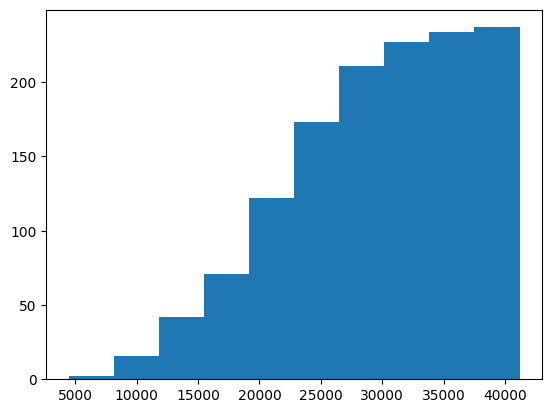

In [20]:
# Add your code here:
plt.hist(X_transform['thalach'], bins=10, cumulative=True)

In [21]:
X_transform.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
132,29,1,2,1.744980,6.761990,0,2,41185.865573,0,-0.000000,1,0.0,3.0
202,57,1,3,1.755323,6.018348,1,0,29597.395635,0,0.173734,1,1.0,7.0
196,69,1,1,1.759742,6.979813,1,2,16371.731775,0,0.092927,2,1.0,3.0
75,65,0,3,1.759742,7.681503,0,2,22152.479330,0,0.504536,1,0.0,3.0
176,52,1,4,1.730388,6.972972,1,0,20921.719976,0,0.092927,1,3.0,7.0


In [22]:
y_transform.head()


,num
132,0
202,0
196,0
75,0
176,0


In [23]:
X_test_transform.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
179,53,1,3,1.744980,7.059886,1,2,29597.395635,0,-0.000000,1,3.0,3.0
228,54,1,4,1.731895,6.777389,0,2,10861.038280,1,-0.000000,2,1.0,3.0
111,56,1,4,1.742009,7.079348,1,2,20023.237344,1,0.643604,2,1.0,3.0
246,58,1,4,1.723908,6.979813,0,0,23743.815930,0,0.092927,1,1.0,7.0
60,51,0,4,1.744980,7.408235,0,0,19435.922742,1,0.643604,2,0.0,7.0


In [24]:
y_test_clean.head()

,num
179,0
228,1
111,1
246,1
60,1


In [25]:
# Add your code here:
X_train_dis = X_transform.copy(deep=True)
y_train_dis = y_transform.copy(deep=True)
X_train_dis['thalach'], bin = pd.qcut(X_train_dis['thalach'], q=10, labels=[i for i in range(10)], retbins=True)

print(bin)
# bin[0] = min(bin[0], X_test_transform['thalach'].min())
# bin[-1] = max(bin[-1], X_test_transform['thalach'].max())

# discrete performance

print(X_train_dis.head())
X_test_dis = X_test_transform.copy(deep=True)
y_test_dis = y_test_clean.copy(deep=True)
# print(X_test_transform['thalach'].head())
X_test_dis['thalach'] = pd.cut(X_test_dis['thalach'], bins=bin, labels=[i for i in range(10)])

# X_test_dis.loc[X_test_transform['thalach'] < bin[0], 'thalach'] = 0
# X_test_dis.loc[X_test_transform['thalach'] > bin[-1], 'thalach'] = 9

print(X_test_dis.head())
# print(X_test_dis['thalach'].head())
#print(X_test_dis.isna().mean()*100)
#print(X_test_dis['thalach'])


[ 4465.12647027 13395.43705746 16159.97417984 19377.89032232
 20921.71997644 22466.03817877 24726.92959038 26070.89805773
 28443.13677224 30628.81477025 41185.86557259]
     age  sex  cp  trestbps      chol  fbs  restecg thalach  exang   oldpeak  \
132   29    1   2  1.744980  6.761990    0        2       9      0 -0.000000   
202   57    1   3  1.755323  6.018348    1        0       8      0  0.173734   
196   69    1   1  1.759742  6.979813    1        2       2      0  0.092927   
75    65    0   3  1.759742  7.681503    0        2       4      0  0.504536   
176   52    1   4  1.730388  6.972972    1        0       3      0  0.092927   

     slope   ca  thal  
132      1  0.0   3.0  
202      1  1.0   7.0  
196      2  1.0   3.0  
75       1  0.0   3.0  
176      1  3.0   7.0  
     age  sex  cp  trestbps      chol  fbs  restecg thalach  exang   oldpeak  \
179   53    1   3  1.744980  7.059886    1        2       8      0 -0.000000   
228   54    1   4  1.731895  6.777389    0    

In [26]:
model_dis = support_vector_machine.train(X_train_dis, y_train_dis)
support_vector_machine.evaluate(model_dis, X_train_dis, y_train_dis, X_test_dis, y_test_dis)

Score on training set: 71.31%
Score on test set: 76.67%


(array([24., 24., 23., 26., 22., 26., 26., 18., 24., 24.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

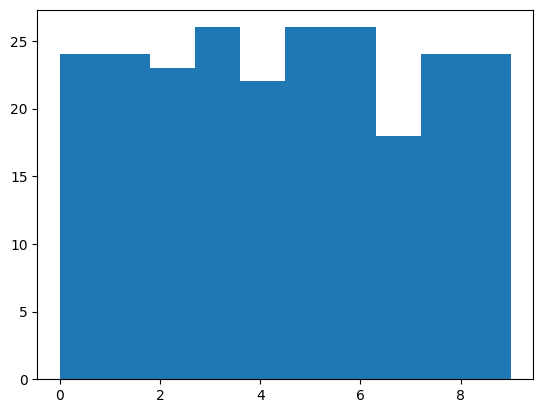

In [27]:
# Add your code here:
plt.hist(X_train_dis['thalach'], bins=10)

<div class="alert alert-block alert-danger">
<b>Q: Why has discretising <code>thalach</code> improved the model's performance?</b>
</div>

**A:** Argue: does not necessarily improve; depends on what features transformed

<hr>

## 4. Feature selection


In this section, our goal is to reduce the number of inputs that the model requires to make a prediction, without losing too much performance. In fact, as we'll see, sometimes selecting only the most relevant features can even *boost* performance.

We want to select **5** input features, from the 13 possible candidates. We explore a few methods for identifying the most important features.

### 4.1 Using mutual information

`scikit-learn` provides `mutual_info_classif` to approximate the mutual information criterion for classification problems.

In [28]:
from sklearn.feature_selection import mutual_info_classif
help(mutual_info_classif)

Help on function mutual_info_classif in module sklearn.feature_selection._mutual_info:

mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
    Estimate mutual information for a discrete target variable.
    
    Mutual information (MI) [1]_ between two random variables is a non-negative
    value, which measures the dependency between the variables. It is equal
    to zero if and only if two random variables are independent, and higher
    values mean higher dependency.
    
    The function relies on nonparametric methods based on entropy estimation
    from k-nearest neighbors distances as described in [2]_ and [3]_. Both
    methods are based on the idea originally proposed in [4]_.
    
    It can be used for univariate features selection, read more in the
    :ref:`User Guide <univariate_feature_selection>`.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Feature matrix

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 4.1: Identifying important features using mutual information</h4>

- Compute the mutual information criterion for the training data using `mutual_info_classif`. Set the `random_state` parameter to the `seed` variable you defined before.
- Plot a bar chart of the results, where the x-axis labels are column names and the y-axis values are the mutual information between each column and the output variable.
- In the Q/A box, write the column names of the 5 features with highest mutual information with the output.
- Evaluate the model with all 13 features, and with only the top 5 mutual information features. **Has the performance of the model improved, stayed the same, or got worse? What does that tell us about the feature importance?** Answer in the Q/A box.
- Why might a model improve when the number of input features is reduced? Answer in the Q/A box.
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
<b>💎 Tip</b>

- Use the model that has been trained on the data with no NaNs, Yeo-Johnson transformed variables, and binned `thalach`.
- You can use `np.argsort(A)` to get the indices that would sort an array `A`. The indices can then be used to get a sorted version of something else.
- If you get a warning from `sklearn`, replace `y_train` with `np.ravel(y_train)`. This simply flattens the `y_train` array, to ensure that it's 1D.
- For this section, don't modify or overwrite any of the DataFrames! Create new copies, instead.
</div>

In [29]:
# Add your code here:
import numpy as np
mi = mutual_info_classif(X_train_dis, np.ravel(y_transform), random_state=seed)
for feature, score in zip(X_train_dis.columns, mi):
    print(feature, ":", score)
top5_idx = np.argsort(mi)[-5:][::-1]
fea5_train = X_train_dis.iloc[:, top5_idx]
fea5_test = X_test_dis.iloc[:, top5_idx]
# print(fea5_train.head())
# print(fea5_test.head())

age : 0.026211568230847693
sex : 0.0789842617660721
cp : 0.13531286661328168
trestbps : 0.030202428569926942
chol : 0.03437330629813906
fbs : 0.0
restecg : 0.05553873252685637
thalach : 0.05813296943381019
exang : 0.08409812352550361
oldpeak : 0.05540249183610002
slope : 0.05394627902216498
ca : 0.1392826969053147
thal : 0.1137989563864128


<div class="alert alert-block alert-danger">
<b>Q: What are the 5 columns with the highest mutual information with the output?</b>
</div>

**A**: ca cp thal exang sex

In [30]:
# Add your code here:
model_5fea = support_vector_machine.train(fea5_train, y_transform)
support_vector_machine.evaluate(model_5fea, fea5_train, y_transform, fea5_test, y_test_clean)

Score on training set: 83.12%
Score on test set: 88.33%


<div class="alert alert-block alert-danger">
<b>Q: Has the model performance improved, stayed the same, or got worse? What does that tell us about the feature importance?</b> 
</div>

**A**: Inproved

<div class="alert alert-block alert-danger">
<b>Q: Why might a model improve when the number of features is reduced?</b> 
</div>

**A**: Reduce overfitting. Increase interpretability

### 4.2 Using SHAP

SHAP is a Python package for computing *Shapley values*, which are an idea from game theory. The basic principle is to **allocate credit for a model’s output among its input features**. Hence, for a given output prediction, we can gain insight into **which input features** contributed to the prediction.

SHAP is a hugely powerful tool, as you can apply it to any machine learning model (even LLMs!) to provide a greater degree of interpretability. However, not many people have heard of it. If you're interested, there's some really cool theory behind it [[paper](https://arxiv.org/abs/1705.07874)].

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 4.2: Identifying important features using Shapley additive values (SHAP)</h4>

- Using `shap.utils.sample`, generate a subset of 100 points from the training set to act as 'background data'. Ideally, we'd use the full training set, but it gets quite slow to compute, so we use a subset for this lab.
- Create a SHAP explainer object using `shap.KernelExplainer`, your background data, and the class probability prediction function from our model (stored in `model.predict_proba`).
- Run the explainer on the test set, storing the result in a variable called `shap_values`.
- Using `shap.plots.bar`, visualise the average SHAP absolute values. What are the top 5 features according to SHAP? Does SHAP agree with the mutual information criterion? Answer in the Q/A box.
- Has the model performance improved, stayed the same, or got worse? What does that tell us about the feature importance?  Answer in the Q/A box.
<details>
<summary>🔎 Hint</summary>
If you're stuck, see whether you can find anything helpful on <a href=https://github.com/shap/shap#sample-notebooks>SHAP's Git repo</a>.
</details>
</div>

<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
<b>💎 Tip</b>

- Use the model that has been trained on the data with no NaNs, Yeo-Johnson transformed variables, and binned `thalach`.
- **Remember to set the random state of the `sample()` function to the `seed` variable from before.**
- Computing SHAP values takes a minute or so, so why not watch [this explanation](https://www.youtube.com/watch?v=MQ6fFDwjuco) of what's going on while your code is running.
- The exact choice of SHAP explainer that you use depends on the model that you want to explain. As the model we're using (nonlinear support vector machine) can be formulated using kernels, we use a `KernelExplainer`. Don't worry if none of those words mean anything to you, it's not important for this course.
</div>

In [31]:
import shap
from shap.utils import sample
from shap import KernelExplainer
shap.initjs()

# Sample 100 datapoints as "background data"
# Add your code here:
bg_train = sample(X_train_dis, 100, random_state=seed)
# Create a SHAP explainer
# Add your code here:
explainer = KernelExplainer(model_dis.predict_proba, bg_train)
# Evaluate the explainer on the test set
# Add your code here:
shap_values = explainer(X_test_dis)
# shap_values is an array of shape (n_samples, n_features, n_outputs)
# Confusingly, although we only have binary outcomes (1 or 0), SHAP still returns 2 outputs
# The output at index 1 is the probability that the patient has heart disease
shap_values = shap_values[:,:,1]


  0%|          | 0/60 [00:00<?, ?it/s]

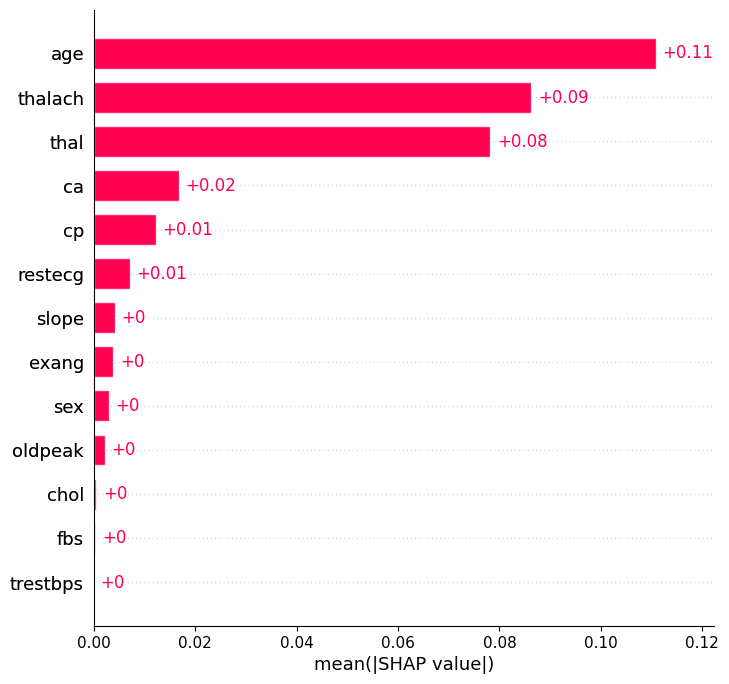

In [32]:
# Plot the SHAP values
# Add your code here:
shap.plots.bar(shap_values, max_display=13)

<div class="alert alert-block alert-danger">
<b>Q: What are the top 5 features according to SHAP? Does SHAP agree with the mutual information criterion?</b> 
</div>

**A:** age, thalach, thal, ca, cp

In [33]:
shap_train = X_train_dis[['age', 'thalach', 'thal', 'ca', 'cp']]
shap_test = X_test_dis[['age', 'thalach', 'thal', 'ca', 'cp']]

In [34]:
# Add your code here:
model_shap = support_vector_machine.train(shap_train, y_transform)
support_vector_machine.evaluate(model_shap, shap_train, y_transform, shap_test, y_test_clean)

Score on training set: 71.73%
Score on test set: 75.00%


<div class="alert alert-block alert-danger">
<b>Q: Has the model performance improved, stayed the same, or got worse? What does that tell us about the feature importance?</b> 
</div>

**A**: Worse than MI

<div class="alert alert-block alert-warning">
<h4>👩‍💻 [Optional] Task 4.2b: Explaining single predictions with SHAP waterfall plots</h4>

SHAP can also be used to understand why the model predicted a particular output class for a particular input.

Using `shap.plots.waterfall`, compare 3 candidates (2 from the same class, and one from the other class). Draw some comparisons between them. For each patient, what are the most significant features? How sure is the model of its predictions?

</div>

In [58]:
print(shap_values)

.values =
array([[-3.56377050e-02,  2.57632685e-03, -2.58614114e-03,
         4.04930492e-05,  6.70528880e-05, -1.07372725e-03,
         6.75636389e-03, -1.17472066e-01, -3.33602095e-03,
        -2.98122975e-03, -4.23561842e-03,  4.29073905e-02,
        -6.89815039e-02],
       [-2.95687013e-03,  2.93058491e-03,  1.66369581e-02,
        -1.67054162e-05, -4.11702310e-04,  2.02499840e-04,
         7.86818047e-03,  1.55208197e-01,  6.16813125e-03,
        -3.33956978e-03,  3.43722427e-03,  8.19997682e-03,
        -7.12321144e-02],
       [ 2.74864027e-02,  2.95894811e-03,  1.65973700e-02,
        -7.02520911e-06,  1.28646507e-04, -1.16821292e-03,
         7.88189129e-03,  4.88465734e-02,  6.22235517e-03,
         1.43695646e-03,  3.47788367e-03,  7.93924128e-03,
        -7.37515665e-02],
       [ 7.02908143e-02,  2.92996550e-03,  1.69509495e-02,
         9.77699160e-06, -4.56647981e-05,  1.80297548e-04,
        -8.81710012e-03, -1.66471893e-02, -3.67059551e-03,
        -2.64989858e-03, -4

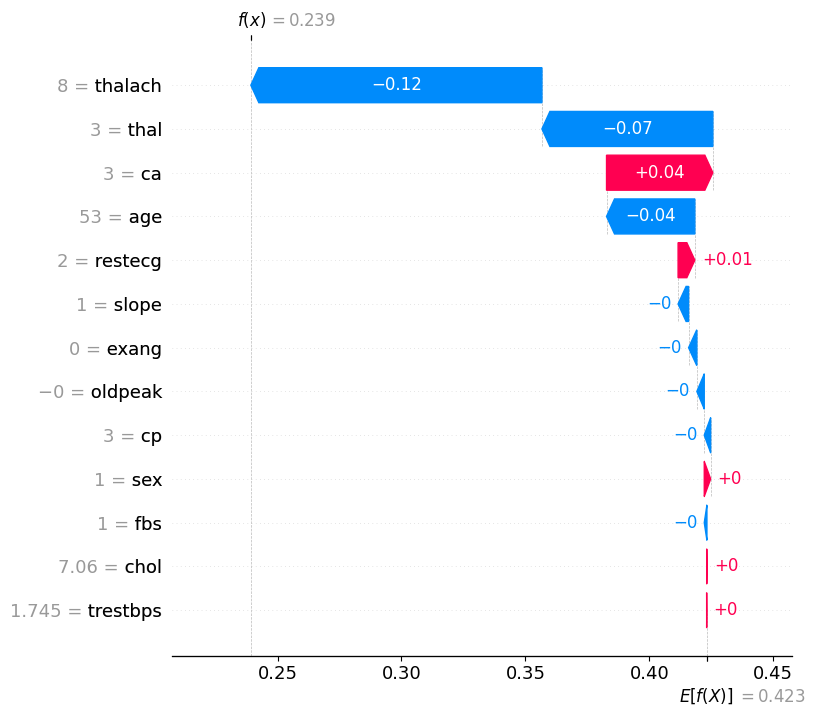

In [60]:
# Add your code here:
shap.plots.waterfall(shap_values[0], max_display=13) # class 0

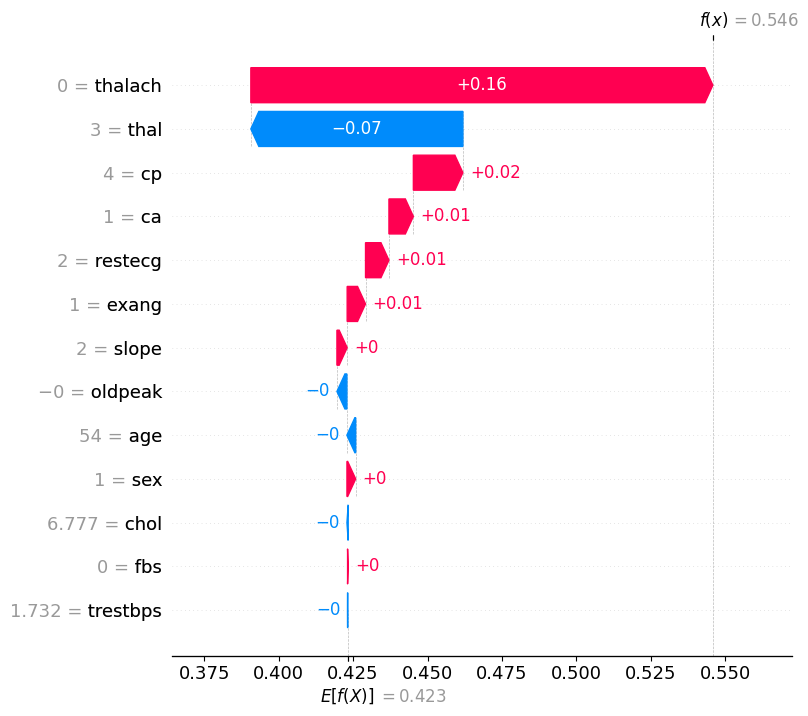

In [61]:
shap.plots.waterfall(shap_values[1], max_display=13) # class 1

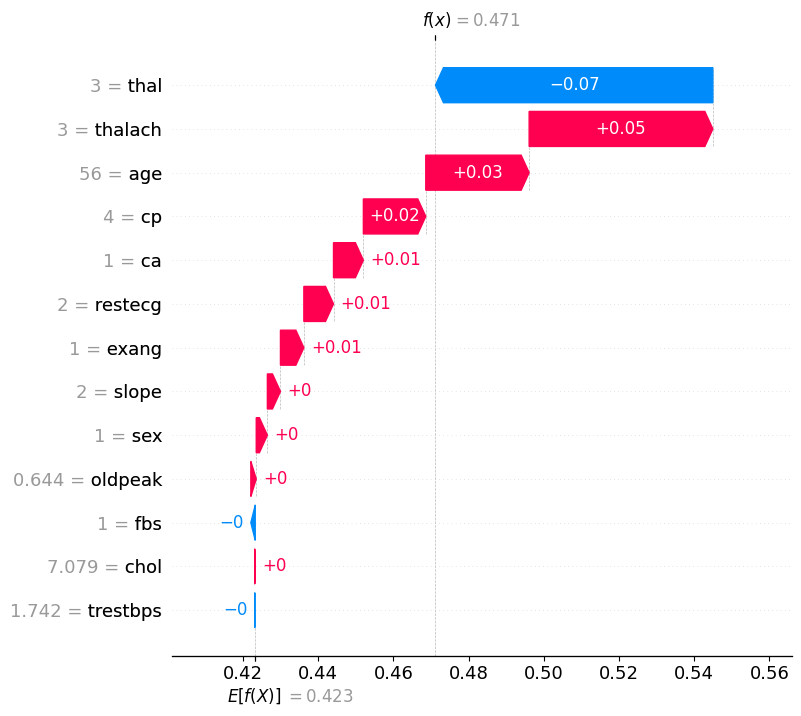

In [62]:
shap.plots.waterfall(shap_values[2], max_display=13) # class 1

<div class="alert alert-block alert-warning">
<b>Q: What are some similarities and differences between the patients? What are the most significant features? How sure is the model of its predictions?</b> 
</div>

**A**: thalach and thal are the most significant features. If f(x) is far from the mean of prediction vertical line it should be more confident

### 4.3 Using principal components

We're not limited to keeping the input features in the same geometrical space that they came in. In fact, there might be a way of projecting the data onto another co-ordinate system where their influence is easier to separate.

One method for doing this is *principal component analysis* (PCA), a concept from linear algebra. PCA effectively involves computing the eigenvalues and eigenvectors of the input data, and then using these as the new co-ordinate basis. In pictures, that looks something like this:

![PCA in 2D](figures/pca.png)

By only keeping the eigenvectors corresponding to the largest eigenvalues, we end up with a reduced set of input coordinates that should explain most of the data.

If you're interested in more detail, check out [this excellent tutorial](https://setosa.io/ev/principal-component-analysis/), which is the source of the above figure.

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 4.3 Identifying important (transformed) features using PCA</h4>

- Scikit-learn provides a PCA function. Find its documentation and use it to compute the first 5 principal components of the training data. Transform the training and test data with these components.
- Compare the model performance with only the first 5 principal components and the whole data. How does the performance compare to the mutual information and SHAP methods? Answer in the Q/A box. 

</div>


In [42]:
# Add your code here:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_train_pca = pd.DataFrame(pca.fit_transform(X_train_dis))
X_test_pca = pca.transform(X_test_dis)

In [43]:
model_pca = support_vector_machine.train(X_train_pca, y_transform)
support_vector_machine.evaluate(model_pca, X_train_pca, y_transform, X_test_pca, y_test_clean)

Score on training set: 79.32%
Score on test set: 85.00%


<div class="alert alert-block alert-danger">
<b>Q: How does the PCA performance compare to the mutual information and SHAP methods?</b> 
</div>

**A**: shap < PCA < MI

<div class="alert alert-block alert-warning">
<h4>👩‍💻 [Optional] Task 4.3b: Quantifying the effect of more principal components</h4>

- With PCA, we can compute how well a given set of principal components represents the data.
- Create a plot showing how the percentage of variance explained by the principal components changes as the number of components is increased from 0 to 13.

<details>
<summary>🔎 Hint</summary>
The PCA object has a property that might be useful in computing the explained variance. The easiest way of generating the plot is with a loop.
</details>
</div>

In [47]:
# Add your code here:
variance_ratio = []
for i in range(1,14):
    pca = PCA(n_components=i)
    X_train_pca = pd.DataFrame(pca.fit_transform(X_train_dis))
    X_test_pca = pca.transform(X_test_dis)
    variance_ratio.append(pca.explained_variance_ratio_)
    print("number of components: ", i)
    model_pca = support_vector_machine.train(X_train_pca, y_transform)
    support_vector_machine.evaluate(model_pca, X_train_pca, y_transform, X_test_pca, y_test_clean)
print(variance_ratio)
    

number of components:  1
Score on training set: 66.67%
Score on test set: 63.33%
number of components:  2
Score on training set: 75.95%
Score on test set: 81.67%
number of components:  3
Score on training set: 76.37%
Score on test set: 81.67%
number of components:  4
Score on training set: 77.22%
Score on test set: 83.33%
number of components:  5
Score on training set: 79.32%
Score on test set: 85.00%
number of components:  6
Score on training set: 80.17%
Score on test set: 85.00%
number of components:  7
Score on training set: 80.59%
Score on test set: 85.00%
number of components:  8
Score on training set: 81.43%
Score on test set: 86.67%
number of components:  9
Score on training set: 81.01%
Score on test set: 86.67%
number of components:  10
Score on training set: 81.43%
Score on test set: 86.67%
number of components:  11
Score on training set: 81.86%
Score on test set: 86.67%
number of components:  12
Score on training set: 81.86%
Score on test set: 86.67%
number of components:  13

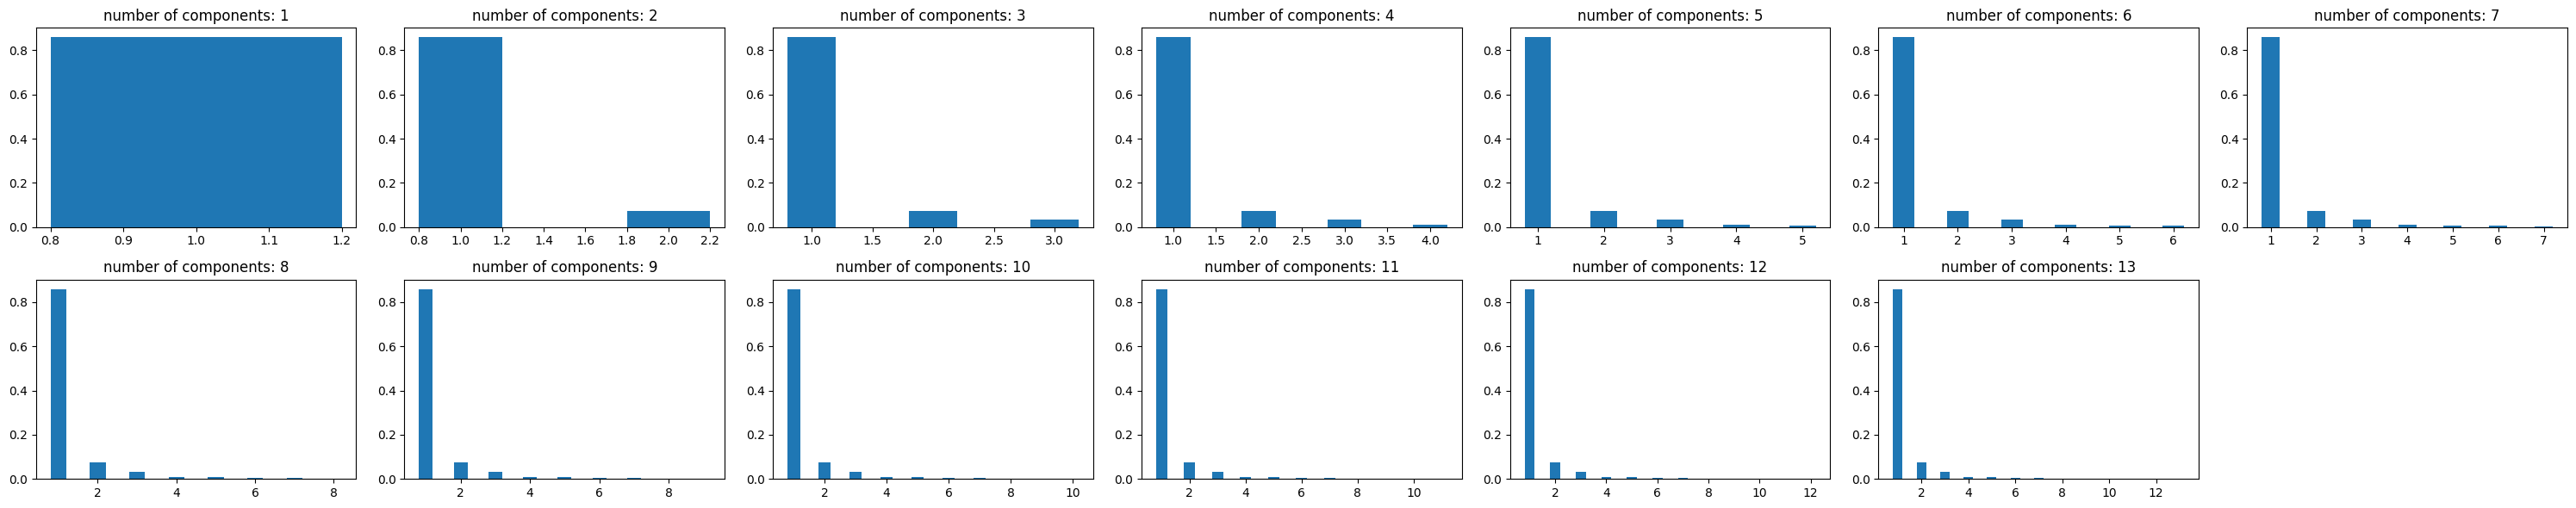

In [56]:
plt.figure(figsize=(30, 6))
for i in range(1,14):
    plt.subplot(2, 7, i)
    #plt.plot([i for i in range(1, i+1)], variance_ratio[i-1])
    plt.bar([i for i in range(1, i+1)], variance_ratio[i-1], width=0.4)
    plt.title(f"number of components: {i}")
plt.tight_layout()

### 4.4 Conclusion

<div class="alert alert-block alert-danger">
<h4>👩‍💻 Task 4.4: Reviewing the results</h4>

- What are the strengths and weaknesses of the feature selection methods we've discussed in this section? Answer in the Q/A box below.
- Your answer should include reference to the **real-world scenario** of this dataset.
- Also consider how the methods are affected by any sources of **randomness**, and how they deal with **correlated features**.
</div>
<div class="alert alert-heading alert-danger" style="background-color: white; border: 2px solid; border-radius: 5px; color: #000; border-color:#AAA; padding: 10px">
<b>💎 Tip</b>

- You might have to carefully revisit the documentation for `mutual_info_classif` to spot how randomness plays a role in this method.
</div>

<div class="alert alert-block alert-danger">
<b>Q: What are the strengths and weaknesses of the feature selection methods we've discussed in this section?</b> 
</div>

**A**: *add your answer here*